# Importing Dataset


In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_resume=pd.read_csv('raw_data/Data_Set_CV_Cleaned_version test.csv')
df_resume.drop(['Unnamed: 0'],axis=1,inplace=True)
df_resume=df_resume.rename(columns={'New_Category':'Category','CV_cleaned':'Resume'})
df_resume.dropna(inplace=True)
df_resume=df_resume.drop_duplicates().reset_index(drop=True)


<AxesSubplot: >

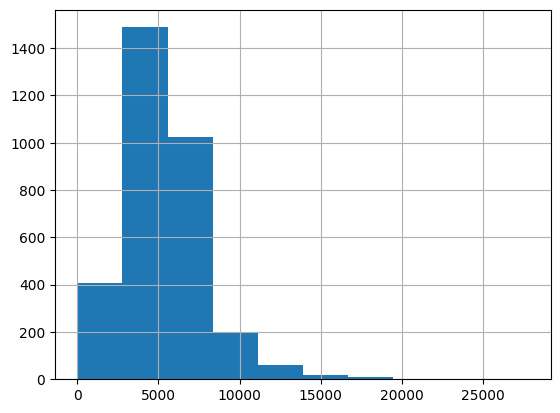

In [6]:
#distributuon des longueurs de CV avant cleaning
df_resume['lenght']=df_resume['Resume'].apply(len)
# df_resume['lenght'].mean()
df_resume['lenght'].hist()

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

# Charger la liste des mots communs en anglais
stop_words = set(stopwords.words('english'))

# Supprimer les stopwords
def data_clean_nltk(x):
    tokens = word_tokenize(x)
    tokens_filtered = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens_filtered)

#supprimer les doublons et les lettres uniques
def data_clean(x):
    words = x.split()
    words_filtered = [word for word in words if len(word) > 2 and word]
    unique_sorted_list = sorted(set(words_filtered))
    return ' '.join(unique_sorted_list)

#supprime les mots dont le sens est identique
lemmatizer = WordNetLemmatizer()
def lemmatize_text(x):
    tokens = word_tokenize(x)
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens_lemmatized)


df_resume['Resume_cleaned'] = df_resume['Resume']
df_resume['Resume_cleaned'] = df_resume['Resume_cleaned'].apply(data_clean_nltk)
df_resume['Resume_cleaned'] = df_resume['Resume_cleaned'].apply(data_clean)
df_resume['Resume_cleaned'] = df_resume['Resume_cleaned'].apply(lemmatize_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathieubartozzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#distribution des longueurs de CV après cleaning
df_resume['new_lenght']=df_resume['Resume_cleaned'].apply(len)
df_resume['new_lenght'].mean()

2539.6465463596764

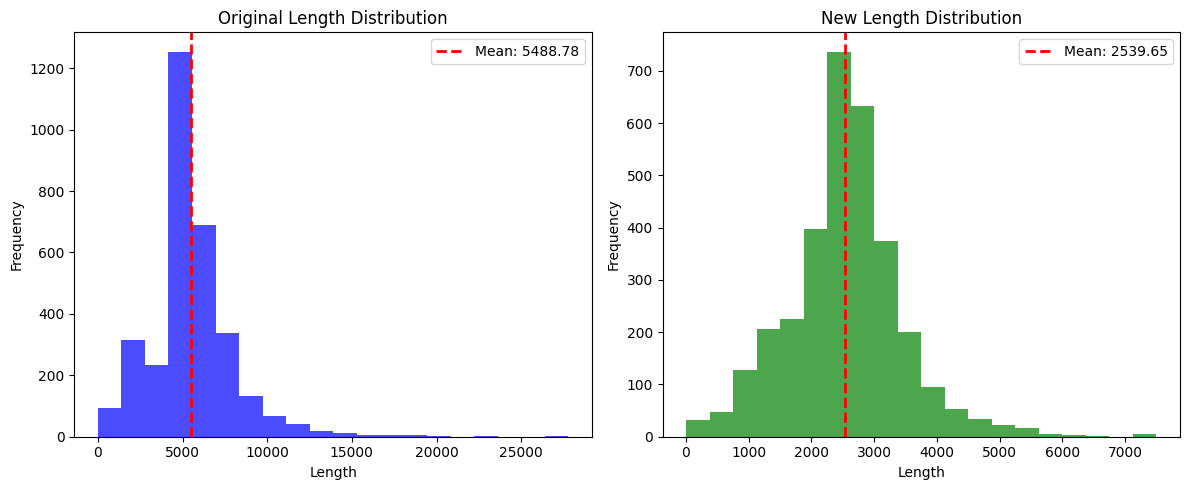

In [9]:
import matplotlib.pyplot as plt

# Calculer la moyenne pour chaque colonne
mean_original = df_resume['lenght'].mean()
mean_new = df_resume['new_lenght'].mean()

# Créer une figure avec deux sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Premier subplot pour df_resume['lenght']
axs[0].hist(df_resume['lenght'], bins=20, color='blue', alpha=0.7)
axs[0].axvline(mean_original, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_original:.2f}')
axs[0].set_title('Original Length Distribution')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Deuxième subplot pour df_resume['new_lenght']
axs[1].hist(df_resume['new_lenght'], bins=20, color='green', alpha=0.7)
axs[1].axvline(mean_new, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_new:.2f}')
axs[1].set_title('New Length Distribution')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Ajuster l'espace entre les subplots pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()

In [10]:
df_resume.head()

,Category,Resume,lenght,Resume_cleaned,new_lenght
0,Technology and IT,skills programming languages python pandas num...,4505,across action address advanced also analysis a...,2459
1,Technology and IT,education details may to may b e uit rgpv da...,1103,achievement aditya arima art attribute auto au...,686
2,Technology and IT,areas of interest deep learning control system...,1748,academy activity add aeronautics aircraft anac...,1050
3,Technology and IT,skills r python sap hana tableau sap hana sql ...,6418,across actively activity advance agent algorit...,2676
4,Technology and IT,education details mca ymcaust faridabad haryan...,397,analysis company core data database descriptio...,201


In [11]:
# len_max=4096
# df_resume_filtred=df_resume[df_resume['new_lenght']<len_max]

In [12]:
num_categories= len(df_resume['Category'].value_counts())
num_categories

15

In [13]:
from sklearn.preprocessing import LabelEncoder
# Convert labels to integers
label_encoder = LabelEncoder()
df_resume['label'] = label_encoder.fit_transform(df_resume['Category'])

In [14]:
df_resume.head()

,Category,Resume,lenght,Resume_cleaned,new_lenght,label
0,Technology and IT,skills programming languages python pandas num...,4505,across action address advanced also analysis a...,2459,12
1,Technology and IT,education details may to may b e uit rgpv da...,1103,achievement aditya arima art attribute auto au...,686,12
2,Technology and IT,areas of interest deep learning control system...,1748,academy activity add aeronautics aircraft anac...,1050,12
3,Technology and IT,skills r python sap hana tableau sap hana sql ...,6418,across actively activity advance agent algorit...,2676,12
4,Technology and IT,education details mca ymcaust faridabad haryan...,397,analysis company core data database descriptio...,201,12


# Reduction des donnéees

In [15]:
import nltk
nltk.download('punkt')
df_resume['tokenized'] = df_resume['Resume_cleaned'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathieubartozzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convertir les listes de mots en phrases (documents)
documents = [' '.join(words) for words in df_resume['tokenized']]

# Utiliser TF-IDF pour transformer les documents en vecteurs
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Créer un DataFrame avec les résultats TF-IDF
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())


In [17]:
# Sélectionner les termes avec les valeurs TF-IDF les plus élevées
n_top_terms=512
important_terms = df_tfidf.sum().sort_values(ascending=False).index[:n_top_terms].tolist()
df_resume['reduced_summary'] = df_resume['tokenized'].apply(lambda x: [word for word in x if word in important_terms])


<AxesSubplot: >

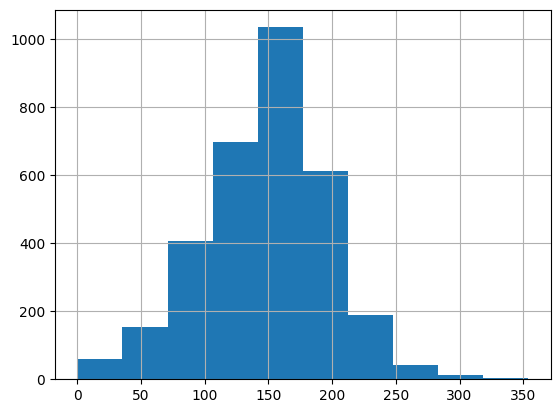

In [18]:
df_resume['reduced_summary_lenght']=df_resume['reduced_summary'].apply(len)
df_resume['reduced_summary_lenght'].hist()


# Pre Train model : BERT

In [19]:
df_resume

,Category,Resume,lenght,Resume_cleaned,new_lenght,label,tokenized,reduced_summary,reduced_summary_lenght
0,Technology and IT,skills programming languages python pandas num...,4505,across action address advanced also analysis a...,2459,12,"[across, action, address, advanced, also, anal...","[across, action, advanced, also, analysis, ass...",113
1,Technology and IT,education details may to may b e uit rgpv da...,1103,achievement aditya arima art attribute auto au...,686,12,"[achievement, aditya, arima, art, attribute, a...","[art, business, company, data, description, de...",23
2,Technology and IT,areas of interest deep learning control system...,1748,academy activity add aeronautics aircraft anac...,1050,12,"[academy, activity, add, aeronautics, aircraft...","[activity, analysis, area, august, based, basi...",50
3,Technology and IT,skills r python sap hana tableau sap hana sql ...,6418,across actively activity advance agent algorit...,2676,12,"[across, actively, activity, advance, agent, a...","[across, activity, also, analysis, analytical,...",141
4,Technology and IT,education details mca ymcaust faridabad haryan...,397,analysis company core data database descriptio...,201,12,"[analysis, company, core, data, database, desc...","[analysis, company, core, data, database, desc...",13
...,...,...,...,...,...,...,...,...,...
3209,Education and Training,summary seasoned agriculture teacher with more...,5516,ability able academic achieve achieving activi...,2301,2,"[ability, able, academic, achieve, achieving, ...","[ability, able, achieve, activity, activity, a...",124
3210,Education and Training,summary dependable and resourceful instructor ...,7654,academic academic achieve achievement acrobat ...,3037,2,"[academic, academic, achieve, achievement, acr...","[achieve, activity, administration, analysis, ...",193
3211,Engineering and Construction,summary candidate with a fifteen months experi...,5178,achieve achieved actual adjusting advantage am...,2571,3,"[achieve, achieved, actual, adjusting, advanta...","[achieve, analysis, analyzed, application, bac...",114
3212,Engineering and Construction,summary i have recently completed five years o...,6307,achieve acquired action activation active acti...,3064,3,"[achieve, acquired, action, activation, active...","[achieve, action, active, activity, additional...",191


In [20]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"
#model_name = "bert-large-uncased"
#model_name = "allenai/longformer-large-4096"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side = "right")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#Division des données en ensembles d'entraînement, de validation et de test
# Création d'un échantillon aléatoire de  du dataset complet
frac=0.2
sample_df = df_resume.sample(frac=frac, random_state=42)
full_df=df_resume

df=sample_df

df["tokenized"] = df["reduced_summary"].map(lambda x: tokenizer(x)["input_ids"])
df["len_tokenized"] = df["tokenized"].map(lambda x: len(x))


In [22]:
# Concaténer les listes en une seule chaîne de caractères pour chaque entrée
df["reduced_summary_concatenated"] = df["reduced_summary"].apply(lambda x: ' '.join(x))

# Utiliser le tokenizer sur la colonne concaténée
tokenized_tensors = tokenizer(df["reduced_summary_concatenated"].tolist(), max_length=512, padding="max_length", truncation=True, return_tensors="tf")

# Nettoyer la colonne temporaire si nécessaire
df.drop("reduced_summary_concatenated", axis=1, inplace=True)


In [23]:
from sklearn.model_selection import train_test_split

# Diviser le DataFrame en ensembles d'entraînement (70%) et de test (30%)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Extraire les identifiants d'entrée et les étiquettes d'entraînement
X_train = tokenized_tensors["input_ids"][:len(df_train)]
y_train = df_train["label"]

# Extraire les identifiants d'entrée et les étiquettes de test
X_test = tokenized_tensors["input_ids"][len(df_train):]
y_test = df_test["label"]


In [24]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Définir l'arrêt anticipé
early_stopping = EarlyStopping(
    monitor='val_loss',  # Vous pouvez choisir une autre métrique comme 'val_accuracy'
    patience=3,           # Nombre d'époques sans amélioration après lesquelles l'entraînement s'arrête
    restore_best_weights=True  # Restaurer les poids du modèle de la meilleure époque
)

# Compiler le modèle avec l'optimiseur Adam hérité
optimizer = Adam(learning_rate=2e-5)  # Vous pouvez ajuster le taux d'apprentissage selon vos besoins

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher la structure du modèle
model.summary()

# Entraîner le modèle
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,  # Vous pouvez ajuster le nombre d'époques
    callbacks=[early_stopping]  # Ajouter l'arrêt anticipé
)

# Évaluer sur l'ensemble de test
test_results = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_results[1])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


In [ ]:
# Sauvegarder le modèle
import joblib

joblib.dump(classification_model, 'models/bert_model.pkl')